# Project-6: Анализ результатов A/B-теста для НКО Tochno

Цель: провести анализ результатов A/B тестирования для НКО статистическими методами

In [1]:
# импортируем необходимые библиотеки для анализа данных
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import Image

# импортируем данные с результатами тестирования и создаем DataFrame
data = pd.read_csv('ab_test_results.csv')
# приводим данные к верному типу данных
data['Day Index'] = pd.to_datetime(data['Day Index'], 
                                   format='%Y-%m-%d'
)
# создаем доп.признак в DataFrame
data['Conversion'] = data['Email Subscriptions'] / data['Users']

data.head()

,Day Index,Users,Email Subscriptions,Group Type,Conversion
0,2020-07-08,170,1,control,0.005882
1,2020-07-08,142,3,test,0.021127
2,2020-07-09,100,1,control,0.010000
3,2020-07-09,95,5,test,0.052632
4,2020-07-10,170,2,control,0.011765


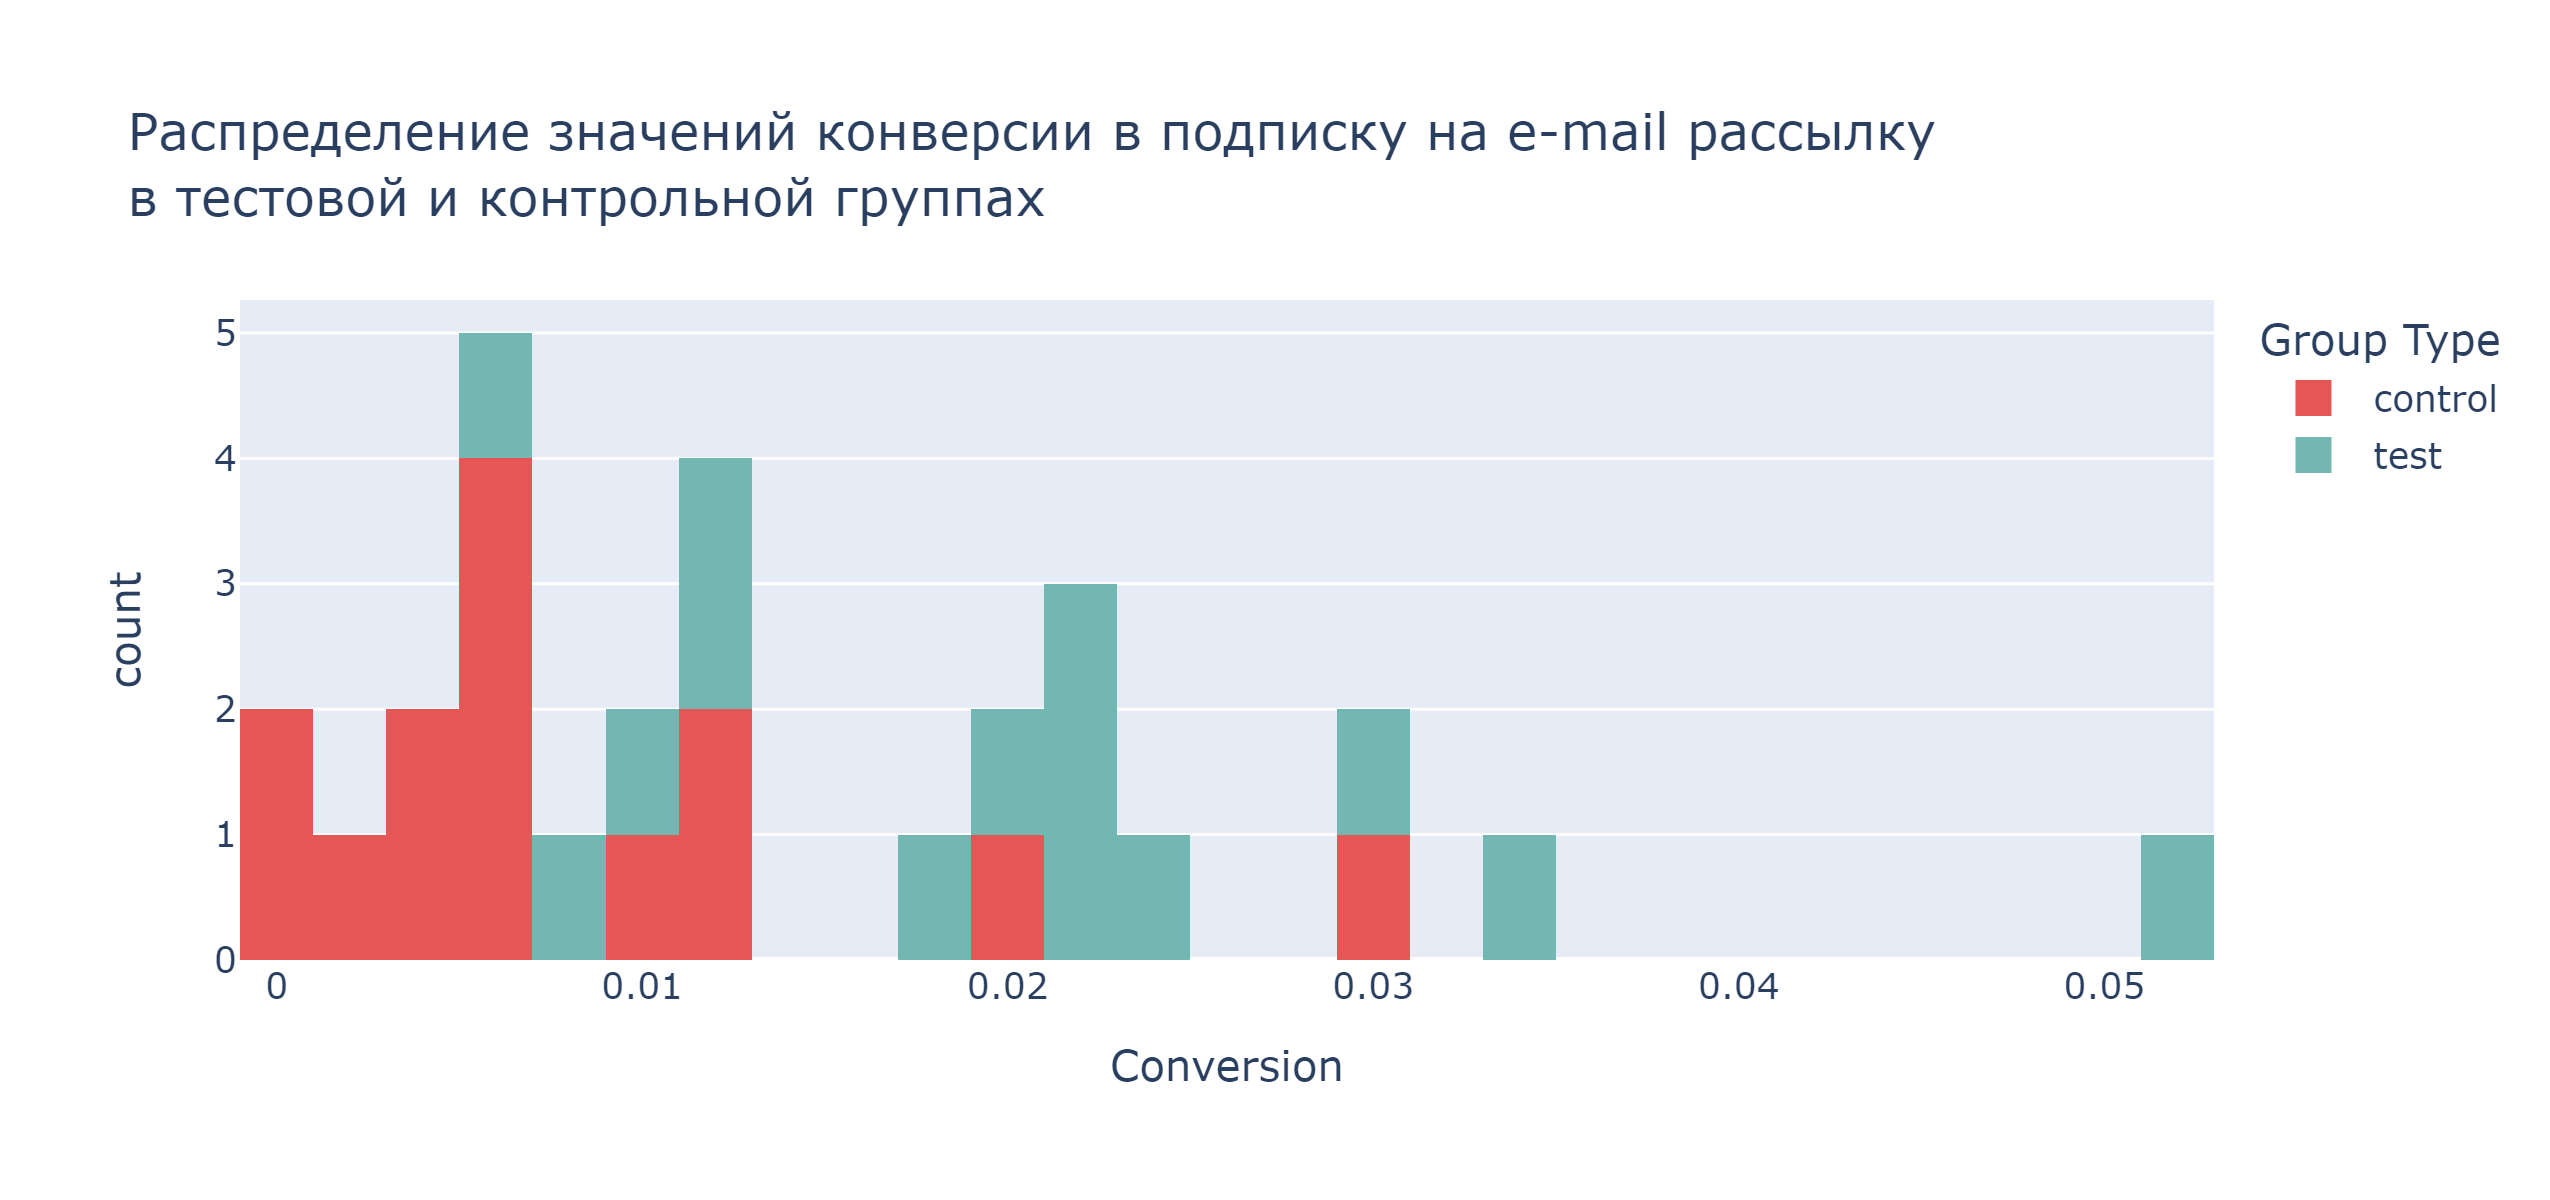

In [2]:
# создаем визуализацию распределения конверсии в тестовой и контрольной группах
fig = px.histogram(data, 
                   x='Conversion', 
                   color='Group Type', 
                   nbins=40,
                   color_discrete_sequence=px.colors.qualitative.T10[2::1],
                   title='Распределение значений конверсии в подписку на e-mail рассылку<br>в тестовой и контрольной группах')

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

In [3]:
# создаем переменные с количеством пользователей в группах и подписок 
# для сравнения конверсий в тестовой и контрольной группах
success_test = data[data['Group Type'] == 'test']['Email Subscriptions'].sum()
size_test = data[data['Group Type'] == 'test']['Users'].sum()
conversion_test = success_test / size_test

success_control = data[data['Group Type'] == 'control']['Email Subscriptions'].sum()
size_control = data[data['Group Type'] == 'control']['Users'].sum()
conversion_control = success_control / size_control


print(f'Количество конверсий в подписку в тестовой группе: {success_test}')
print(f'Размер тестовой группы: {size_test}')
print(f'Конверсия в покупку в тестовой группе: {round(conversion_test, 4)}')
print()
print(f'Количество конверсий в контрольной группе: {success_control}')
print(f'Размер контрольной группы: {size_control}')
print(f'Конверсия в подписку в контрольной группе: {round(conversion_control, 4)}')
print()
print(f'Отношение конверсии тестовой группы к контрольной: {round(conversion_test / conversion_control, 2)}')

Количество конверсий в подписку в тестовой группе: 49
Размер тестовой группы: 2663
Конверсия в покупку в тестовой группе: 0.0184

Количество конверсий в контрольной группе: 18
Размер контрольной группы: 2476
Конверсия в подписку в контрольной группе: 0.0073

Отношение конверсии тестовой группы к контрольной: 2.53


In [4]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

successes = np.array([success_test, success_control])
samples = np.array([size_test, size_control])

statistic, p_value = proportions_ztest(count=successes, 
                                       nobs=samples, 
                                       alternative='two-sided')
print(f'statistic: {round(statistic, 4)}')
print(f'p_value: {round(p_value, 4)}')

statistic: 3.5147
p_value: 0.0004


Значение p-value меньше уровня значимости в 5%, что говорит о том, что мы можем сказать, что разница в конверсии в подписку в контрольной и тестовой группах имеет статистическую значимость.

Однако, для того, чтобы однозначно так сказать, необходимо проверить полученные данные на нормальность распределения. Иными словами, мы должны понять репрезентативны ли полученные данные.

In [5]:
# импортируем библиотеку scipy.stats
from scipy.stats import shapiro
# определяем значение критерия Шапиро-Уилка
stat, p_value = shapiro(data['Conversion'])
print(f'stat={stat}, p-value={p_value}')

alpha = 0.05
if p_value > alpha: # H0 - распределеие нормальное, H1 - распределение ненормальное
    print('Fail to reject H0, sample looks Gaussian')
else:
    print('Reject H0, sample is not Gaussian')

stat=0.886634349822998, p-value=0.005643473006784916
Reject H0, sample is not Gaussian


Данные полученные в результате проведенного A/B тестирования не соответствую критерия нормальности. Следовательно, нам необходимо трансформировать данные, чтобы понять есть ли действительно статистическая разница в конверсии в подписку в контрольной и тестовой группах.

Применим метод бустрэп-семплирования.

100%|██████████| 10000/10000 [00:00<00:00, 17547.73it/s]


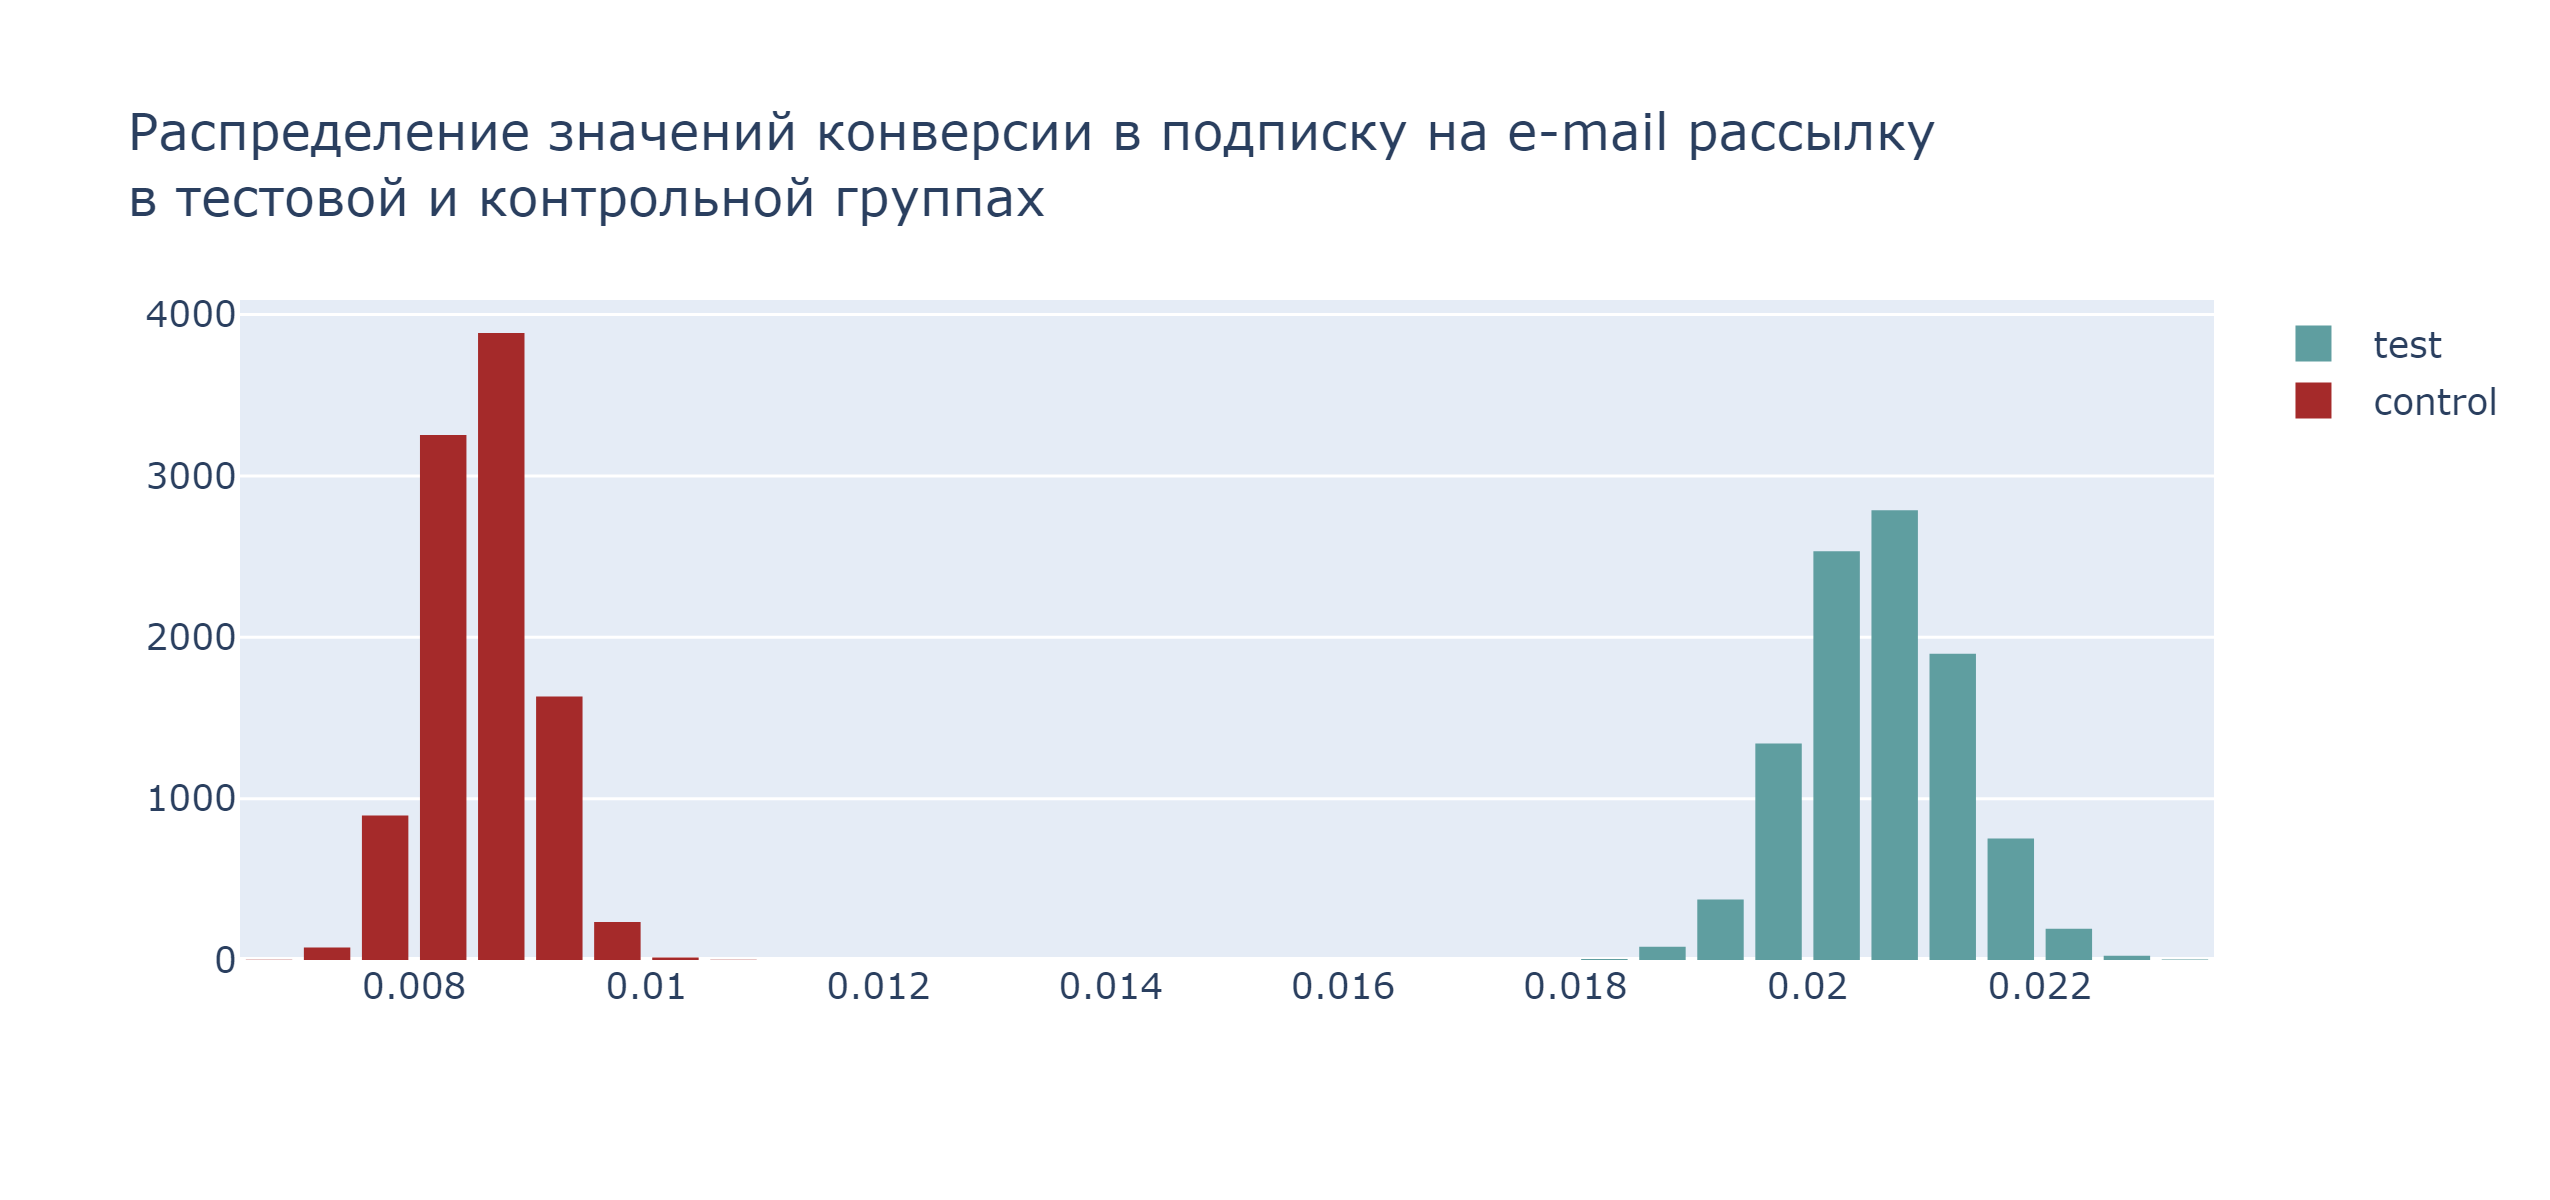

In [6]:
# импортируем библиотеку tqdm
from tqdm import tqdm
# создаем списки со значениями конверсии в тестовой и контрольной 
# группах в период тестирования
test_all_values = data[data['Group Type'] == 'test']['Conversion'].values.tolist()
control_all_values = data[data['Group Type'] == 'control']['Conversion'].values.tolist()
# создаем пустые списки, где будут находиться значения конверсии в группах
sample_mean_test = []
sample_mean_control = []

# устанавливаем seed
np.random.seed(2)

# 10 000 раз берем случайные выборки из 300 значений конверсий тестовой и контрольной групп, 
# среднее каждой выборки сохраняем в созданных списках 
for i in tqdm(range(10000)):
    sample = np.random.choice(test_all_values, size = 300)
    sample_mean_test.append(np.mean(sample))
    
    sample = np.random.choice(control_all_values, size=300)
    sample_mean_control.append(np.mean(sample))

# создаем визуализацию распределения конверсии в тестовой и контрольной группах
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=sample_mean_test, 
                           name='test',
                           marker_color="cadetblue"))
fig.add_trace(go.Histogram(x=sample_mean_control, 
                           name='control',
                           marker_color="brown"))

fig.update_layout(title_text='Распределение значений конверсии в подписку на e-mail рассылку<br>в тестовой и контрольной группах', 
                  showlegend=True)

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

Заметно, что распределения разные, и распределение в тестовой группе явно находится правее контрольного. То есть матожидание в тестовой группе точно выше, чем в контрольной.

Посмотрим на квантили по каждому из распределений, чтобы узнать, является ли разница статистически значимой. Для этого обратим внимание на 95 перцентиль у контрольной группы и 5 перцентиль у тестовой группы. Если первое значение будет меньше второго, значит, пересечение этих распределений меньше 5% и разность между ними статистически значимая.

In [7]:
print(f'Control 95 percentile: {np.percentile(sample_mean_control, 95)}')
print(f'Test 5 percentile: {np.percentile(sample_mean_test, 5)}')

Control 95 percentile: 0.009348445241087541
Test 5 percentile: 0.019522357872955403


Действительно, 5 перцентиль у тестовой группы значительно больше 95 перцентиля у контрольной группы, что подтверждает, что разница в конверсии в подписку в группах не случайна и имеет статистическую значимость.

Рассчитаем эффект при масштабирования нового визуала на всю аудиторию сайта проекта Tochno.

100%|██████████| 10000/10000 [00:00<00:00, 26287.89it/s]


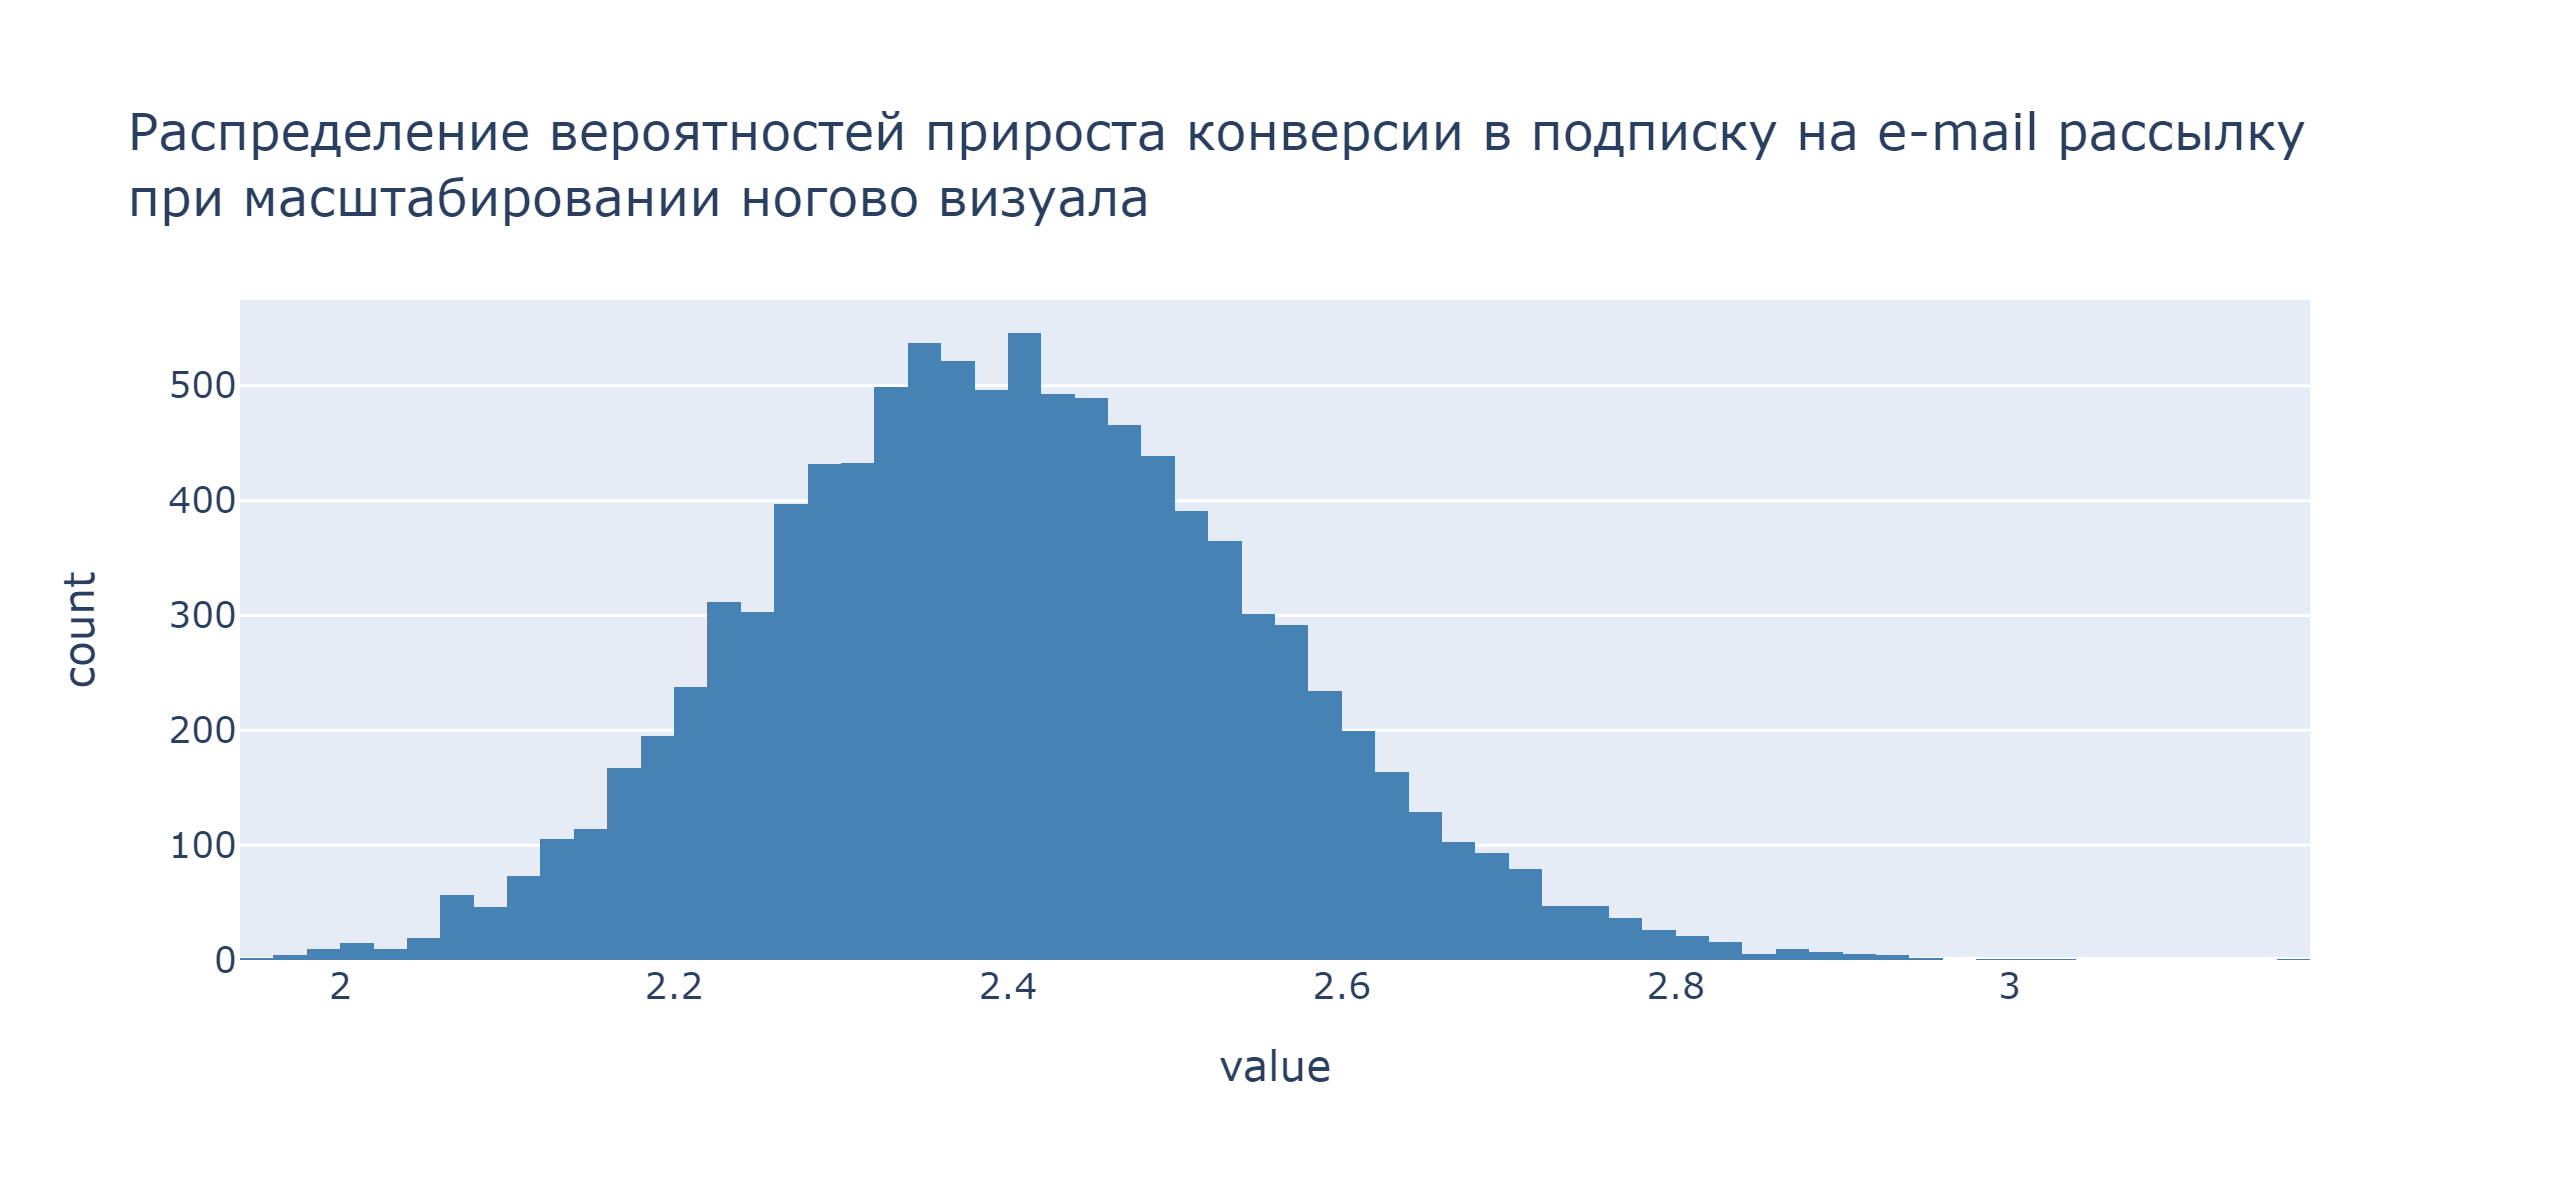

In [8]:
# создаем списки со значениями конверсии в тестовой и контрольной группах в период тестирования
test_all_values = data[data['Group Type'] == 'test']['Conversion'].values.tolist()
control_all_values = data[data['Group Type'] == 'control']['Conversion'].values.tolist()

# устанавливаем seed
np.random.seed(1)

# создаем пустой список для отношения конверсии в тестовой группе к контрольной 
sample_mean_ratio = []

# 10 000 раз берем случайные выборки из 300 значений конверсий тестовой и контрольной групп 
for i in tqdm(range(10000)):
    sample_test = np.random.choice(test_all_values, size=300)
    sample_control = np.random.choice(control_all_values, size=300)
    # делим среднее значение выборки тестовой группы на среднее контрольной и добавляем в список sample_test_ration
    sample_mean_ratio.append(sample_test.mean()/sample_control.mean())

# создаем визуализацию распределения вероятностей прироста конверсии из списка sample_test_ratio в подписку относительно текущей конверсии
fig = px.histogram(sample_mean_ratio, 
                   nbins=100,
                   color_discrete_sequence=['steelblue'],
                   title='Распределение вероятностей прироста конверсии в подписку на e-mail рассылку<br>при масштабировании ногово визуала')

fig.update_layout(showlegend=False)

# создаем статическую визуализацию для отображение на github
# при запуске кода use fig.show()
img = fig.to_image(format="png", width=850, height=400, scale=3, engine="orca")
Image(img)

In [9]:
print(f'Реальный прирост конверсии при масштабировании нового визуала лежит в \
пределах интервала от {round(np.percentile(sample_mean_ratio, 2.5), 2)} до {round(np.percentile(sample_mean_ratio, 97.5), 2)} раз')

Реальный прирост конверсии при масштабировании нового визуала лежит в пределах интервала от 2.12 до 2.71 раз


In [10]:
print('Размах:', 
      abs(np.percentile(sample_mean_ratio, 2.5) - np.percentile(sample_mean_ratio, 97.5)))

Размах: 0.5911774727843429


Распределение вероятностей прироста конверсии показывает, что при масштабировании нового визуала на всю аудиторию, реальный прирост конверсии посетителей сайта будет находится в интервале от 2,12 до 2,71. Т.е. даже при достижении минимального уровня ожидаемой конверсии в подписку, прирост конверсии будет в 2 раза больше нынешнего уровня.

## Выводы:

Эксперимент прошел успешно, конверсия в подписку в тестовой группе оказалась больше конверсии в контрольной группе в 2,53 раза. 

Тестирование проводилось инструментами Google Optimize. 
Размер тестовой и контрольной групп 2 663 и 2 476 человек соответственно.
Срок проведения тестирования - 2 недели.

По окончанию тестирования конверсия в тестовой группе 1,84%, конверсия в контрольной группе - 0,73%. Статистическая значимость разницы в конверсии тестовой и контрольной групп была подтверждена с помощью метода бустреп-семплирования.

Таким образом, мы считаем проверяемую гипотезу успешной и рекомендуем масштабировать новый визуал на всю аудиторию. В этом случае прирост конверсии в подписку с вероятностью 95% составит от 2,12 до 2,71 раз. Т.е. даже если будет достигнут только минимальный ожидаемый показатель конверсии, он будет больше нынешнего в 2 раза.